# Model Experiments - Trajectory VAE

This notebook demonstrates training and experimenting with the trajectory VAE model using the fake NetMob25 dataset.

In [1]:
import sys
sys.path.append('..')

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, TensorDataset
import pickle
from tqdm.notebook import tqdm

from ml_mobility_ns3 import (
    NetMob25Loader,
    TrajectoryPreprocessor,
    ConditionalTrajectoryVAE,
    VAETrainer,
    TrajectoryGenerator,
)
from ml_mobility_ns3.utils.visualization import (
    plot_trajectory,
    plot_multiple_trajectories,
    plot_training_history,
    create_folium_map,
)

# Set style
sns.set_style('darkgrid')
sns.set_palette('husl')

# Check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


## 1. Load and Prepare Data

In [2]:
# Load fake data
data_dir = Path("../data/netmob25")
if not data_dir.exists():
    print("Fake data not found! Run 'python generate_fake_data.py' first.")
    raise FileNotFoundError("Data directory not found")

loader = NetMob25Loader(data_dir)

# Load datasets
individuals = loader.load_individuals()
trips = loader.load_trips()

print(f"Loaded {len(individuals)} individuals")
print(f"Loaded {len(trips)} trips")

Loaded 3337 individuals
Loaded 80697 trips


/Users/raphaelcousin/ml_mobility_ns3/ml_mobility_ns3/data/loader.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.trips_df[col] = pd.to_datetime(self.trips_df[col], errors='coerce')
/Users/raphaelcousin/ml_mobility_ns3/ml_mobility_ns3/data/loader.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.trips_df[col] = pd.to_datetime(self.trips_df[col], errors='coerce')


Sampling trajectories...
Sampled 500 valid trajectories


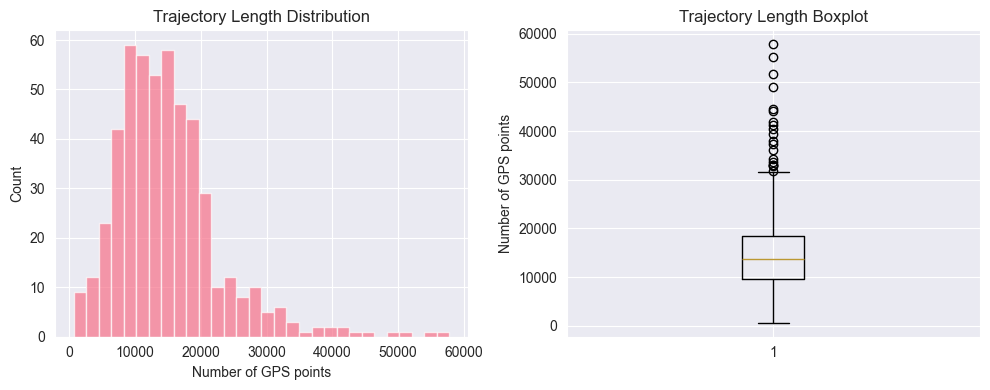

Mean trajectory length: 14970.7
Median trajectory length: 13782.0


In [3]:
# Sample trajectories
print("Sampling trajectories...")
trajectories = loader.sample_trajectories(n_samples=500, min_points=10)
print(f"Sampled {len(trajectories)} valid trajectories")

# Show trajectory length distribution
traj_lengths = [len(t) for t in trajectories]
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(traj_lengths, bins=30, alpha=0.7)
plt.xlabel('Number of GPS points')
plt.ylabel('Count')
plt.title('Trajectory Length Distribution')

plt.subplot(1, 2, 2)
plt.boxplot(traj_lengths)
plt.ylabel('Number of GPS points')
plt.title('Trajectory Length Boxplot')

plt.tight_layout()
plt.show()

print(f"Mean trajectory length: {np.mean(traj_lengths):.1f}")
print(f"Median trajectory length: {np.median(traj_lengths):.1f}")

In [4]:
trajectories

[            UTC DATETIME       LOCAL DATETIME VALID   LATITUDE  LONGITUDE  \
 0    2023-01-26 07:12:00  2023-01-26 08:12:00   SPS  49.001340   2.874893   
 1    2023-01-26 07:12:02  2023-01-26 08:12:02   SPS  49.001340   2.874893   
 2    2023-01-26 07:12:04  2023-01-26 08:12:04   SPS  49.001340   2.874893   
 3    2023-01-26 07:12:06  2023-01-26 08:12:06   SPS  49.001340   2.874893   
 4    2023-01-26 07:12:08  2023-01-26 08:12:08   SPS  49.001340   2.874893   
 ...                  ...                  ...   ...        ...        ...   
 4449 2023-01-27 07:11:26  2023-01-27 08:11:26   SPS  49.001664   2.873286   
 4450 2023-01-27 07:11:28  2023-01-27 08:11:28   SPS  49.001664   2.873286   
 4451 2023-01-27 07:11:30  2023-01-27 08:11:30   SPS  49.001664   2.873286   
 4452 2023-01-27 07:11:32  2023-01-27 08:11:32   SPS  49.001664   2.873286   
 4453 2023-01-27 07:11:34  2023-01-27 08:11:34   SPS  49.001664   2.873286   
 
        SPEED  
 0      2.050  
 1      2.100  
 2      5.925 

## 2. Data Preprocessing

In [5]:
# Create preprocessor
sequence_length = 20000  # Fixed sequence length
preprocessor = TrajectoryPreprocessor(sequence_length=sequence_length)

# Split data
n_train = int(len(trajectories) * 0.7)
n_val = int(len(trajectories) * 0.15)

train_trajectories = trajectories[:n_train]
val_trajectories = trajectories[n_train:n_train+n_val]
test_trajectories = trajectories[n_train+n_val:]

print(f"Train: {len(train_trajectories)}")
print(f"Val: {len(val_trajectories)}")
print(f"Test: {len(test_trajectories)}")

# Fit preprocessor on training data
preprocessor.fit(train_trajectories)

# Transform data
train_data = preprocessor.transform(train_trajectories)
val_data = preprocessor.transform(val_trajectories)
test_data = preprocessor.transform(test_trajectories)

print(f"\nData shapes:")
print(f"Train: {train_data.shape}")
print(f"Val: {val_data.shape}")
print(f"Test: {test_data.shape}")

Train: 350
Val: 75
Test: 75


KeyboardInterrupt: 

In [ ]:
train_data

In [ ]:
# Visualize preprocessed data
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Sample trajectory features
sample_idx = 0
sample_features = train_data[sample_idx]

# Plot each feature
feature_names = ['Latitude', 'Longitude', 'Time (min)', 'Speed']
for i, (ax, name) in enumerate(zip(axes.flat, feature_names)):
    ax.plot(sample_features[:, i])
    ax.set_xlabel('Sequence index')
    ax.set_ylabel(f'{name} (normalized)')
    ax.set_title(f'{name} over trajectory')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Model Training

In [ ]:
# Model hyperparameters
model_config = {
    'input_dim': 4,  # lat, lon, time, speed
    'sequence_length': sequence_length,
    'hidden_dim': 64,
    'latent_dim': 16,
    'num_layers': 2,
}

# Create model
model = ConditionalTrajectoryVAE(**model_config)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Create trainer
trainer = VAETrainer(
    model,
    device=device,
    learning_rate=1e-3,
    beta=0.5,  # Beta for KL weighting
)

In [ ]:
# Train the model
print("Training model...")
trainer.fit(
    train_data,
    val_data,
    epochs=150,
    batch_size=32,
)

# Plot training history
fig = plot_training_history(trainer.history)
plt.show()

## 4. Model Evaluation

In [ ]:
# Evaluate on test set
model.eval()
test_tensor = torch.FloatTensor(test_data).to(device)

with torch.no_grad():
    recon, mu, logvar = model(test_tensor)
    
    # Calculate reconstruction error
    recon_error = torch.mean((recon - test_tensor) ** 2, dim=(1, 2))
    mean_recon_error = recon_error.mean().item()
    
print(f"Test reconstruction error: {mean_recon_error:.4f}")

# Plot reconstruction error distribution
plt.figure(figsize=(8, 4))
plt.hist(recon_error.cpu().numpy(), bins=30, alpha=0.7)
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Count')
plt.title('Test Set Reconstruction Error Distribution')
plt.show()

In [ ]:
# Visualize some reconstructions
n_examples = 3
indices = np.random.choice(len(test_data), n_examples, replace=False)

fig, axes = plt.subplots(n_examples, 2, figsize=(12, 8))

for i, idx in enumerate(indices):
    # Get original and reconstructed
    original = test_data[idx]
    with torch.no_grad():
        recon_norm = model(torch.FloatTensor(original).unsqueeze(0).to(device))[0]
        recon_norm = recon_norm.cpu().numpy()[0]
    
    # Inverse transform
    original_traj = preprocessor.inverse_transform([original])[0]
    recon_traj = preprocessor.inverse_transform([recon_norm])[0]
    
    # Plot trajectories
    ax1, ax2 = axes[i]
    
    # Original
    ax1.plot(original_traj[:, 1], original_traj[:, 0], 'b.-', alpha=0.7, label='Original')
    ax1.set_title(f'Original Trajectory {idx}')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.grid(True, alpha=0.3)
    
    # Reconstructed
    ax2.plot(recon_traj[:, 1], recon_traj[:, 0], 'r.-', alpha=0.7, label='Reconstructed')
    ax2.set_title(f'Reconstructed Trajectory {idx}')
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Trajectory Generation

In [ ]:
# Create generator
generator = TrajectoryGenerator(model, preprocessor, device=device)

# Generate new trajectories
n_generated = 10
generated_trajectories = generator.generate(n_samples=n_generated)

print(f"Generated {len(generated_trajectories)} trajectories")

# Convert to DataFrames for visualization
generated_dfs = [generator.to_dataframe(traj) for traj in generated_trajectories]

# Plot generated trajectories
fig = plot_multiple_trajectories(
    generated_dfs[:5],
    title="Generated Trajectories",
    figsize=(10, 8)
)
plt.show()

In [ ]:
# Compare generated vs original trajectories
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Original trajectories
for i in range(min(5, len(test_trajectories))):
    traj = test_trajectories[i]
    ax1.plot(traj['LONGITUDE'], traj['LATITUDE'], 'o-', alpha=0.6, markersize=3)
ax1.set_title('Original Trajectories')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.grid(True, alpha=0.3)

# Generated trajectories
for i in range(min(5, len(generated_dfs))):
    traj = generated_dfs[i]
    ax2.plot(traj['LONGITUDE'], traj['LATITUDE'], 'o-', alpha=0.6, markersize=3)
ax2.set_title('Generated Trajectories')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Latent Space Analysis

In [ ]:
# Encode all test trajectories to latent space
model.eval()
latent_codes = []

with torch.no_grad():
    for i in range(0, len(test_data), 32):
        batch = torch.FloatTensor(test_data[i:i+32]).to(device)
        mu, _ = model.encode(batch)
        latent_codes.append(mu.cpu().numpy())

latent_codes = np.vstack(latent_codes)
print(f"Latent codes shape: {latent_codes.shape}")

# Visualize latent space (first 2 dimensions)
if latent_codes.shape[1] >= 2:
    plt.figure(figsize=(8, 6))
    plt.scatter(latent_codes[:, 0], latent_codes[:, 1], alpha=0.6)
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Visualization (First 2 Dimensions)')
    plt.grid(True, alpha=0.3)
    plt.show()

# If latent dim > 2, use PCA
if latent_codes.shape[1] > 2:
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    
    # PCA
    pca = PCA(n_components=2)
    latent_pca = pca.fit_transform(latent_codes)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(latent_pca[:, 0], latent_pca[:, 1], alpha=0.6)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
    plt.title('Latent Space - PCA Projection')
    plt.grid(True, alpha=0.3)
    plt.show()

## 7. Trajectory Interpolation

In [ ]:
# Select two random trajectories for interpolation
idx1, idx2 = np.random.choice(len(test_trajectories), 2, replace=False)
traj1 = test_trajectories[idx1]
traj2 = test_trajectories[idx2]

# Interpolate
n_interpolations = 7
interpolated = generator.interpolate(traj1, traj2, n_steps=n_interpolations)

# Plot interpolation
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Remove extra subplot
fig.delaxes(axes[-1])

for i, (ax, traj) in enumerate(zip(axes[:-1], interpolated)):
    traj_df = generator.to_dataframe(traj)
    ax.plot(traj_df['LONGITUDE'], traj_df['LATITUDE'], 'o-', markersize=4)
    
    if i == 0:
        ax.set_title('Start Trajectory', fontweight='bold')
    elif i == n_interpolations - 1:
        ax.set_title('End Trajectory', fontweight='bold')
    else:
        ax.set_title(f'Interpolation {i}')
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True, alpha=0.3)

plt.suptitle('Trajectory Interpolation in Latent Space', fontsize=16)
plt.tight_layout()
plt.show()

## 8. Hyperparameter Experiments

In [ ]:
# Experiment with different beta values
beta_values = [0.1, 0.5, 1.0, 2.0]
beta_results = []

for beta in beta_values:
    print(f"\nTraining with beta={beta}")
    
    # Create new model
    model_beta = ConditionalTrajectoryVAE(**model_config)
    trainer_beta = VAETrainer(model_beta, device=device, learning_rate=1e-3, beta=beta)
    
    # Quick training
    trainer_beta.fit(
        train_data[:100],  # Use subset for quick experiment
        val_data[:20],
        epochs=20,
        batch_size=32,
    )
    
    # Store results
    beta_results.append({
        'beta': beta,
        'final_loss': trainer_beta.history['train_loss'][-1],
        'history': trainer_beta.history
    })

# Plot results
plt.figure(figsize=(10, 6))
for result in beta_results:
    plt.plot(result['history']['train_loss'], label=f'β={result["beta"]}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss for Different β Values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Experiment with different latent dimensions
latent_dims = [8, 16, 32, 64]
latent_results = []

for latent_dim in latent_dims:
    print(f"\nTraining with latent_dim={latent_dim}")
    
    # Create model with different latent dimension
    config = model_config.copy()
    config['latent_dim'] = latent_dim
    
    model_latent = ConditionalTrajectoryVAE(**config)
    trainer_latent = VAETrainer(model_latent, device=device, learning_rate=1e-3, beta=0.5)
    
    # Quick training
    trainer_latent.fit(
        train_data[:100],
        val_data[:20],
        epochs=20,
        batch_size=32,
    )
    
    # Generate sample
    gen = TrajectoryGenerator(model_latent, preprocessor, device=device)
    sample = gen.generate(n_samples=1)[0]
    
    latent_results.append({
        'latent_dim': latent_dim,
        'final_loss': trainer_latent.history['train_loss'][-1],
        'sample': sample
    })

# Compare generated samples
fig, axes = plt.subplots(1, len(latent_dims), figsize=(16, 4))
for ax, result in zip(axes, latent_results):
    ax.plot(result['sample'][:, 1], result['sample'][:, 0], 'o-', markersize=4)
    ax.set_title(f'Latent Dim = {result["latent_dim"]}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True, alpha=0.3)

plt.suptitle('Generated Trajectories with Different Latent Dimensions', fontsize=14)
plt.tight_layout()
plt.show()

## 9. Save Model and Results

In [ ]:
# Save the best model
output_dir = Path("../output/notebook_experiment")
output_dir.mkdir(parents=True, exist_ok=True)

# Save model
model_path = output_dir / "best_model.pt"
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': model_config,
    'preprocessor': preprocessor,
    'training_history': trainer.history,
}, model_path)

print(f"Model saved to {model_path}")

# Save preprocessor separately
with open(output_dir / "preprocessor.pkl", "wb") as f:
    pickle.dump(preprocessor, f)

# Save some generated trajectories
generated_df = pd.concat(generated_dfs, ignore_index=True)
generated_df.to_csv(output_dir / "generated_trajectories.csv", index=False)

print(f"Saved {len(generated_dfs)} generated trajectories")

## 10. Interactive Map

In [ ]:
# Create interactive map with original and generated trajectories
map_trajectories = []

# Add some original trajectories
for i in range(min(3, len(test_trajectories))):
    traj = test_trajectories[i].copy()
    traj['type'] = 'original'
    map_trajectories.append(traj)

# Add generated trajectories
for i in range(min(3, len(generated_dfs))):
    traj = generated_dfs[i].copy()
    traj['type'] = 'generated'
    map_trajectories.append(traj)

# Create map
m = create_folium_map(map_trajectories)
m.save(str(output_dir / "trajectories_map.html"))
print(f"Interactive map saved to {output_dir / 'trajectories_map.html'}")

# Display in notebook
m

## Summary

In this notebook, we:
1. Loaded and preprocessed the fake NetMob25 data
2. Trained a VAE model for trajectory generation
3. Evaluated reconstruction quality
4. Generated new realistic trajectories
5. Analyzed the latent space representation
6. Demonstrated trajectory interpolation
7. Experimented with different hyperparameters
8. Saved the trained model and results

The model successfully learns to generate realistic trajectories that resemble the training data patterns.